In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel('data_full_5sekres.xlsx')

In [68]:
df1 = df.copy()

In [69]:
#Create a column of load profile
df1['Load'] = df1['thrusterAndPropulsion']
df1['BaseLoad'] = 300
df1.loc[df1['operationId'] == 100, 'BaseLoad'] = 500
df1.loc[df1['operationId'] == 3, 'BaseLoad'] = 550
df1.loc[df1['operationId'] == 5, 'BaseLoad'] = 510
df1.loc[df1['operationId'] == 6, 'BaseLoad'] = 250
df1.loc[df1['operationId'] == 1, 'BaseLoad'] = 250
df1.loc[df1['operationId'] == 7, 'BaseLoad'] = 380
df1['Load'] = df1['thrusterAndPropulsion'] + df1['BaseLoad']

df1['Battery'] = 0
df1['SOC'] = 0
#Create dataset with only relevant columns
df3 = df1[['datetime', 'Load', 'engMdoPower_0_','engMdoPower_1_','engMdoPower_2_', 'engMdoPower_3_', 'operationId', 'BaseLoad', 'Battery', 'SOC']]

#Set engine powers to zero
num = df3['engMdoPower_0_']._get_numeric_data()
num[num != 0] = 0

num = df3['engMdoPower_1_']._get_numeric_data()
num[num != 0] = 0

num = df3['engMdoPower_2_']._get_numeric_data()
num[num != 0] = 0

num = df3['engMdoPower_3_']._get_numeric_data()
num[num != 0] = 0


,datetime,Load,engMdoPower_0_,engMdoPower_1_,engMdoPower_2_,engMdoPower_3_,operationId,BaseLoad,Battery,SOC
0,2020-01-30 00:00:00,250.0,0.0,0.0,0,0.0,6.0,250,0,0
1,2020-01-30 00:00:05,250.0,0.0,0.0,0,0.0,6.0,250,0,0
2,2020-01-30 00:00:10,250.0,0.0,0.0,0,0.0,6.0,250,0,0
3,2020-01-30 00:00:15,250.0,0.0,0.0,0,0.0,6.0,250,0,0
4,2020-01-30 00:00:20,250.0,0.0,0.0,0,0.0,6.0,250,0,0
...,...,...,...,...,...,...,...,...,...,...
120955,2020-02-05 23:59:35,2046.0,0.0,0.0,0,0.0,3.0,550,0,0
120956,2020-02-05 23:59:40,1993.2,0.0,0.0,0,0.0,3.0,550,0,0
120957,2020-02-05 23:59:45,1975.6,0.0,0.0,0,0.0,3.0,550,0,0
120958,2020-02-05 23:59:50,2010.8,0.0,0.0,0,0.0,3.0,550,0,0


# Shore charging, spinning reserve and peakshaving

In [111]:
df5 = df3.copy()

load = df5['Load'].values
dg0 = df5['engMdoPower_0_'].values
dg1 = df5['engMdoPower_1_'].values
dg2 = df5['engMdoPower_2_'].values
dg3 = df5['engMdoPower_3_'].values
bat = df5['Battery'].values
soc = [0]*120960
soc[0] = 496 #124 empty (20%)
opid = df5['operationId'].values
shore = [0]*120960
efbat = 0.92 #baterreyyy efficiency


# DP mode, battery is used for spinning reserve 
for i in range(len(load)):
    if i == 120959:
        pass
    elif opid[i] == 100:
        
        if load[i] <= 2100 and soc[i] >= 200:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and soc[i] < 200:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
            
        elif load[i] > 2100 and soc[i] >= 200:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 2100 and soc[i] < 200:
            dg0[i] = dg1[i] = dg3[i] = load[i]/3
            soc[i+1] = soc[i]         

        else:
            soc[i+1] = soc[i]
            
#Transit mode
    elif opid[i] == 3 or opid[i] == 5:
        if load[i] <= 1000 and soc[i] < 496:
            dg0[i] = 1000
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - (bat[i]*efbat)/720
        elif load[i] <= 1000 and soc[i] >= 496:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i+1] <= 2100 and load[i] > 1000:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i+1] > 2100 and load[i] > 1000:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] > 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif load[i] > 2100 and load[i-2] < 2100 and soc[i] > 124: # if the load is over 2100 for less than 10 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - bat[i]/720            
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] <= 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-2] < 2100 and soc[i] <= 124: # if the load is over 2100 for less than 10 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]           
        elif load[i] <= 4200 and load[i-1] > 2100:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 4200:
            dg0[i] = dg1[i] = 2100
            bat[i] = load[i] - dg0[i] - dg1[i]
            soc[i+1] = soc[i] - bat[i]/720
        else:
            soc[i+1] = soc[i]
        
#Standby mode
    elif opid[i] == 7:
        if load[i] <= 1000 and soc[i] < 496:
            dg0[i] = 1000
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - (bat[i]*efbat)/720
        elif load[i] <= 1000 and soc[i] >= 496:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i+1] <= 2100 and load[i] > 1000:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i+1] > 2100 and load[i] > 1000:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] > 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif load[i] > 2100 and load[i-2] < 2100 and soc[i] > 124: # if the load is over 2100 for less than 10 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - bat[i]/720
            
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] <= 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-2] < 2100 and soc[i] <= 124: # if the load is over 2100 for less than 10 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]          
            
        elif load[i] <= 4200 and load[i-1] > 2100:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 4200:
            dg0[i] = dg1[i] = 2100
            bat[i] = load[i] - dg0[i] - dg1[i]
            soc[i+1] = soc[i] - bat[i]/720
        else:
            soc[i+1] = soc[i]
            
# port
    elif opid[i] == 1 and soc[i] < 496:
        dg0[i] = load[i]# - bat[i]*1.08
        soc[i+1] = soc[i]# - bat[i]/720
    elif opid[i] == 1 and soc[i] >= 496:
        dg0[i] = load[i]
        soc[i+1] = soc[i]    
    elif opid[i] == 6 and soc[i] < 496:
        bat[i] = -50
        shore[i] = load[i] - bat[i]
        soc[i+1] = soc[i] - (bat[i]*efbat)/720
    elif opid[i] == 6 and soc[i] >= 496:
        shore[i] = load[i]
        soc[i+1] = soc[i] 
    else:
        soc[i+1] = soc[i]
        dg0[i] = load[i]


In [112]:
# Normalize Generators
dg0n = (dg0-dg0.min()) / (2100 - dg0.min())
dg1n = (dg1-dg1.min()) / (2100 - dg1.min())
dg2n = (dg2-dg2.min()) / (2100 - dg2.min())
dg3n = (dg3-dg3.min()) / (2100 - dg3.min())


In [113]:
fc_dg0 = np.zeros(120960)
fc_dg1 = np.zeros(120960)
fc_dg2 = np.zeros(120960)
fc_dg3 = np.zeros(120960)

for i in range(len(dg0)):
    if dg0[i] == 0:
        fc_dg0[i] = 0
    else:
        fc_dg0[i] = (445*dg0n[i] + 47)/720
        
for i in range(len(dg1)):
    if dg1[i] == 0:
        fc_dg1[i] = 0
    else:
        fc_dg1[i] = (445*dg1n[i] + 47)/720
        
for i in range(len(dg2)):
    if dg2[i] == 0:
        fc_dg2[i] = 0
    else:
        fc_dg2[i] = (445*dg2n[i] + 47)/720
        
for i in range(len(dg3)):
    if dg3[i] == 0:
        fc_dg3[i] = 0
    else:
        fc_dg3[i] = (445*dg3n[i] + 47)/720

In [114]:
fc = sum(fc_dg0) + sum(fc_dg1) + sum(fc_dg2) + sum(fc_dg3)
print('Total fuel consumption of CASE 1 batteri 20% batteri start er: ', fc, 'liter')

Total fuel consumption of CASE 1 batteri 20% batteri start er:  39908.1973745741 liter


# bruk batteri 1000kW med en gang og lad i port

In [123]:
df6 = df3.copy()

load = df6['Load'].values
dg0 = df6['engMdoPower_0_'].values
dg1 = df6['engMdoPower_1_'].values
dg2 = df6['engMdoPower_2_'].values
dg3 = df6['engMdoPower_3_'].values
bat = df6['Battery'].values
soc = [0]*120960
soc[0] = 496 #124 empty (20%)
opid = df6['operationId'].values
shore = [0]*120960
efbat = 0.92

# DP mode, battery is used for spinning reserve 
for i in range(len(load)):
    if i == 120959:
        pass
    
    # DP-mode
    elif opid[i] == 100:
        
        if load[i] <= 2100 and soc[i] >= 200:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and soc[i] < 200:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
            
        elif load[i] > 2100 and soc[i] >= 200:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 2100 and soc[i] < 200:
            dg0[i] = dg1[i] = dg3[i] = load[i]/3
            soc[i+1] = soc[i]         

        else:
            soc[i+1] = soc[i]
        
#Transit mode
    elif opid[i] == 3 or opid[i] == 5:
        if soc[i] > 124 and load[i] <= 1000:
            bat[i] = load[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif soc[i] > 124 and load[i] > 1000 and load[i] <= 3100:
            bat[i] = 1000
            dg0[i] = load[i] - bat[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif soc[i] > 124 and load[i] > 3100:
            bat[i] = 1000
            dg0[i] = dg1[i] = (load[i]-bat[i])/2
        elif soc[i] <= 124 and load[i] <= 2100:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif soc[i] <= 124 and load[i] > 2100:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        else:
            soc[i+1] = soc[i]
        
# Standby mode
    elif opid[i] == 7:
        if soc[i] > 124 and load[i] <= 1000:
            bat[i] = load[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif soc[i] > 124 and load[i] > 1000 and load[i] <= 3100:
            bat[i] = 1000
            dg0[i] = load[i] - bat[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif soc[i] > 124 and load[i] > 3100:
            bat[i] = 1000
            dg0[i] = dg1[i] = (load[i]-bat[i])/2
        elif soc[i] <= 124 and load[i] <= 2100:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif soc[i] <= 124 and load[i] > 2100:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        else:
            soc[i+1] = soc[i]
            
#Port
    elif opid[i] == 1:
        if soc[i] > 124 and load[i] <= 1000:
            bat[i] = load[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif soc[i] > 124 and load[i] > 1000 and load[i] <= 3100:
            bat[i] = 1000
            dg0[i] = load[i] - bat[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif soc[i] > 124 and load[i] > 3100:
            bat[i] = 1000
            dg0[i] = dg1[i] = (load[i]-bat[i])/2
        elif soc[i] <= 124 and load[i] <= 2100:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif soc[i] <= 124 and load[i] > 2100:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        else:
            soc[i+1] = soc[i]
    elif opid[i] == 6:
        if soc[i] < 496:
            bat[i] = -100
            soc[i+1] = soc[i] - (bat[i]*efbat)/720
            shore[i] = load[i] - bat[i]
        elif soc[i] >= 496:
            shore[i] = load[i]
            soc[i+1] = soc[i]
        else:
            soc[i+1] = soc[i]
    else:
        soc[i+1] = soc[i]
        dg0[i] = load[i]

In [124]:
# Normalize Generators
dg0n = (dg0-dg0.min()) / (2100 - dg0.min())
dg1n = (dg1-dg1.min()) / (2100 - dg1.min())
dg2n = (dg2-dg2.min()) / (2100 - dg2.min())
dg3n = (dg3-dg3.min()) / (2100 - dg3.min())

In [125]:
fc_dg0 = np.zeros(120960)
fc_dg1 = np.zeros(120960)
fc_dg2 = np.zeros(120960)
fc_dg3 = np.zeros(120960)

for i in range(len(dg0)):
    if dg0[i] == 0:
        fc_dg0[i] = 0
    else:
        fc_dg0[i] = (445*dg0n[i] + 47)/720
        
for i in range(len(dg1)):
    if dg1[i] == 0:
        fc_dg1[i] = 0
    else:
        fc_dg1[i] = (445*dg1n[i] + 47)/720
        
for i in range(len(dg2)):
    if dg2[i] == 0:
        fc_dg2[i] = 0
    else:
        fc_dg2[i] = (445*dg2n[i] + 47)/720
        
for i in range(len(dg3)):
    if dg3[i] == 0:
        fc_dg3[i] = 0
    else:
        fc_dg3[i] = (445*dg3n[i] + 47)/720

In [126]:
fc = sum(fc_dg0) + sum(fc_dg1) + sum(fc_dg2) + sum(fc_dg3)
print('Total fuel consumption of CASE 1 batteri 20% batteri start og gønn battery er: ', fc, 'liter')

Total fuel consumption of CASE 1 batteri 20% batteri start og gønn battery er:  41338.586422973 liter


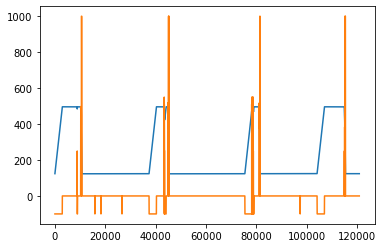

In [80]:
plt.plot(soc)#[9200:11600])
plt.plot(bat)#[9200:11600])

# Batteri kjører 100 kW stadig vekk

In [130]:
df7 = df3.copy()

load = df7['Load'].values
dg0 = df7['engMdoPower_0_'].values
dg1 = df7['engMdoPower_1_'].values
dg2 = df7['engMdoPower_2_'].values
dg3 = df7['engMdoPower_3_'].values
bat = df7['Battery'].values
soc = [0]*120960
soc[0] = 310 #124 empty (20%)
opid = df7['operationId'].values
shore = [0]*120960

# DP mode, battery is used for spinning reserve 
for i in range(len(load)):
    if i == 120959:
        pass
    
    # DP-mode
    elif opid[i] == 100:
        
        if load[i] <= 2100 and soc[i] >= 200:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and soc[i] < 200:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
            
        elif load[i] > 2100 and soc[i] >= 200:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 2100 and soc[i] < 200:
            dg0[i] = dg1[i] = dg3[i] = load[i]/3
            soc[i+1] = soc[i]         

        else:
            soc[i+1] = soc[i]
        
#Transit mode
    elif opid[i] == 3 or opid[i] == 5:
        if soc[i] > 124 and load[i] <= 2200:
            bat[i] = 100
            dg0[i] = load[i] - bat[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif soc[i] > 124 and load[i] > 2200 and load[i] < 4300:
            bat[i] = 100
            dg0[i] = dg1[i] = (load[i]-bat[i])/2
            soc[i+1] = soc[i]
        elif soc[i] <= 124 and load[i] <= 2100:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif soc[i] <= 124 and load[i] > 2100:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        else:
            soc[i+1] = soc[i]
        
# Standby mode
    elif opid[i] == 7:
        if soc[i] > 124 and load[i] <= 2200:
            bat[i] = 100
            dg0[i] = load[i] - bat[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif soc[i] > 124 and load[i] > 2200 and load[i] < 4300:
            bat[i] = 100
            dg0[i] = dg1[i] = (load[i]-bat[i])/2
            soc[i+1] = soc[i]
        elif soc[i] <= 124 and load[i] <= 2100:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif soc[i] <= 124 and load[i] > 2100:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        else:
            soc[i+1] = soc[i]
#Port
    elif opid[i] == 1:
        if soc[i] > 124 and load[i] <= 2200:
            bat[i] = 100
            dg0[i] = load[i] - bat[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif soc[i] > 124 and load[i] > 2200 and load[i] < 4300:
            bat[i] = 100
            dg0[i] = dg1[i] = (load[i]-bat[i])/2
            soc[i+1] = soc[i]
        elif soc[i] <= 124 and load[i] <= 2100:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif soc[i] <= 124 and load[i] > 2100:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        else:
            soc[i+1] = soc[i]
    elif opid[i] == 6:
        if soc[i] < 496:
            bat[i] = -100
            soc[i+1] = soc[i] - bat[i]/720
            shore[i] = load[i] - bat[i]
        elif soc[i] >= 496:
            shore[i] = load[i]
            soc[i+1] = soc[i]
        else:
            soc[i+1] = soc[i]
    else:
        soc[i+1] = soc[i]
        dg0[i] = load[i]

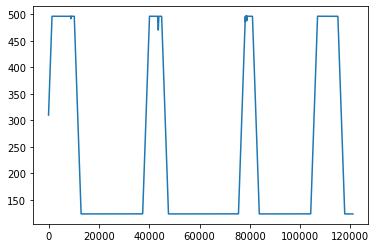

In [131]:
plt.plot(soc)

In [132]:
# Normalize Generators
dg0n = (dg0-dg0.min()) / (2100 - dg0.min())
dg1n = (dg1-dg1.min()) / (2100 - dg1.min())
dg2n = (dg2-dg2.min()) / (2100 - dg2.min())
dg3n = (dg3-dg3.min()) / (2100 - dg3.min())

fc_dg0 = np.zeros(120960)
fc_dg1 = np.zeros(120960)
fc_dg2 = np.zeros(120960)
fc_dg3 = np.zeros(120960)

for i in range(len(dg0)):
    if dg0[i] == 0:
        fc_dg0[i] = 0
    else:
        fc_dg0[i] = (445*dg0n[i] + 47)/720
        
for i in range(len(dg1)):
    if dg1[i] == 0:
        fc_dg1[i] = 0
    else:
        fc_dg1[i] = (445*dg1n[i] + 47)/720
        
for i in range(len(dg2)):
    if dg2[i] == 0:
        fc_dg2[i] = 0
    else:
        fc_dg2[i] = (445*dg2n[i] + 47)/720
        
for i in range(len(dg3)):
    if dg3[i] == 0:
        fc_dg3[i] = 0
    else:
        fc_dg3[i] = (445*dg3n[i] + 47)/720

fc = sum(fc_dg0) + sum(fc_dg1) + sum(fc_dg2) + sum(fc_dg3)
print('Total fuel consumption of CASE 1 batteri 20% batteri start og gønn battery 100 er: ', fc, 'liter')

Total fuel consumption of CASE 1 batteri 20% batteri start og gønn battery 100 er:  41466.142560170876 liter


# Peakshaving i overgang fra 1 til 2 generatorer

In [148]:
df5 = df3.copy()

load = df5['Load'].values
dg0 = df5['engMdoPower_0_'].values
dg1 = df5['engMdoPower_1_'].values
dg2 = df5['engMdoPower_2_'].values
dg3 = df5['engMdoPower_3_'].values
bat = df5['Battery'].values
soc = [0]*120960
soc[0] = 496 #124 empty (20%)
opid = df5['operationId'].values
shore = [0]*120960
efbat = 0.92



# DP mode, battery is used for spinning reserve 
for i in range(len(load)):
    if i == 120959:
        pass
    elif opid[i] == 100:
        
        if load[i] <= 2100 and soc[i] >= 200:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and soc[i] < 200:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
            
        elif load[i] > 2100 and soc[i] >= 200:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 2100 and soc[i] < 200:
            dg0[i] = dg1[i] = dg3[i] = load[i]/3
            soc[i+1] = soc[i]         

        else:
            soc[i+1] = soc[i]

#Transit mode
    elif opid[i] == 3 or opid[i] == 5:
        if load[i] <= 1000 and soc[i] < 496:
            dg0[i] = 1000
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - (bat[i]*efbat)/720
        elif load[i] <= 1000 and soc[i] >= 496:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i] > 1000:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i] <= 3000 and soc[i] > 124: 
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif load[i] > 2100 and load[i] <= 3000 and soc[i] <= 124: 
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 3000:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        else:
            soc[i+1] = soc[i]
        
#Standby mode
    elif opid[i] == 7:
        if load[i] <= 1000 and soc[i] < 496:
            dg0[i] = 1000
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - (bat[i]*efbat)/720
        elif load[i] <= 1000 and soc[i] >= 496:
            dg0[i] = load[i]
            soc[i+1] = soc[i] 
        elif load[i] <= 2100 and load[i] > 1000:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i] <= 3000 and soc[i] > 124: 
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif load[i] > 2100 and load[i] <= 3000 and soc[i] <= 124: 
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 3000: 
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        else:
            soc[i+1] = soc[i]
            
# port
    elif opid[i] == 1 and soc[i] < 496:
        dg0[i] = load[i]# - bat[i]*1.08
        soc[i+1] = soc[i]# - bat[i]/720
    elif opid[i] == 1 and soc[i] >= 496:
        dg0[i] = load[i]
        soc[i+1] = soc[i]    
    elif opid[i] == 6 and soc[i] < 496:
        bat[i] = -100
        shore[i] = load[i] - bat[i]
        soc[i+1] = soc[i] - (bat[i]*efbat)/720
    elif opid[i] == 6 and soc[i] >= 496:
        shore[i] = load[i]
        soc[i+1] = soc[i] 
    else:
        soc[i+1] = soc[i]
        dg0[i] = load[i]


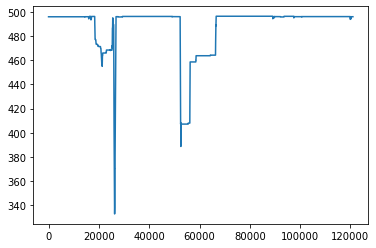

In [149]:
plt.plot(soc)

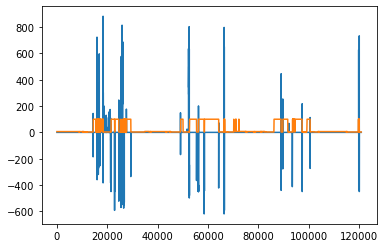

In [150]:
plt.plot(bat)
plt.plot(opid)
#plt.plot(dg1)
#plt.plot(load) #310

In [151]:
# Normalize Generators
dg0n = (dg0-dg0.min()) / (2100 - dg0.min())
dg1n = (dg1-dg1.min()) / (2100 - dg1.min())
dg2n = (dg2-dg2.min()) / (2100 - dg2.min())
dg3n = (dg3-dg3.min()) / (2100 - dg3.min())

fc_dg0 = np.zeros(120960)
fc_dg1 = np.zeros(120960)
fc_dg2 = np.zeros(120960)
fc_dg3 = np.zeros(120960)

for i in range(len(dg0)):
    if dg0[i] == 0:
        fc_dg0[i] = 0
    else:
        fc_dg0[i] = (445*dg0n[i] + 47)/720
        
for i in range(len(dg1)):
    if dg1[i] == 0:
        fc_dg1[i] = 0
    else:
        fc_dg1[i] = (445*dg1n[i] + 47)/720
        
for i in range(len(dg2)):
    if dg2[i] == 0:
        fc_dg2[i] = 0
    else:
        fc_dg2[i] = (445*dg2n[i] + 47)/720
        
for i in range(len(dg3)):
    if dg3[i] == 0:
        fc_dg3[i] = 0
    else:
        fc_dg3[i] = (445*dg3n[i] + 47)/720
        
fc = sum(fc_dg0) + sum(fc_dg1) + sum(fc_dg2) + sum(fc_dg3)
print('Total fuel consumption of CASE 1 batteri mellom 1-2 gen: ', fc, 'liter')

Total fuel consumption of CASE 1 batteri mellom 1-2 gen:  39861.50899750457 liter


# Sjekker utslipp med vår utregning og generator data fra equinor

In [61]:
df10 = df.copy()
dg0 = df10['engMdoPower_0_'].values
dg1 = df10['engMdoPower_1_'].values
dg2 = df10['engMdoPower_2_'].values
dg3 = df10['engMdoPower_3_'].values

# Normalize Generators
dg0n = (dg0-dg0.min()) / (2100 - dg0.min())
dg1n = (dg1-dg1.min()) / (2100 - dg1.min())
dg2n = (dg2-dg2.min()) / (2100 - dg2.min())
dg3n = (dg3-dg3.min()) / (2100 - dg3.min())

fc_dg0 = np.zeros(120960)
fc_dg1 = np.zeros(120960)
fc_dg2 = np.zeros(120960)
fc_dg3 = np.zeros(120960)

for i in range(len(dg0)):
    if dg0[i] == 0:
        fc_dg0[i] = 0
    else:
        fc_dg0[i] = (445*dg0n[i] + 47)/720
        
for i in range(len(dg1)):
    if dg1[i] == 0:
        fc_dg1[i] = 0
    else:
        fc_dg1[i] = (445*dg1n[i] + 47)/720
        
for i in range(len(dg2)):
    if dg2[i] == 0:
        fc_dg2[i] = 0
    else:
        fc_dg2[i] = (445*dg2n[i] + 47)/720
        
for i in range(len(dg3)):
    if dg3[i] == 0:
        fc_dg3[i] = 0
    else:
        fc_dg3[i] = (445*dg3n[i] + 47)/720
        
fc = sum(fc_dg0) + sum(fc_dg1) + sum(fc_dg2) + sum(fc_dg3)
print('Total fuel consumption of CASE 1 batteri mellom 1-2 gen: ', fc, 'liter')

Total fuel consumption of CASE 1 batteri mellom 1-2 gen:  43278.00052810888 liter


# Spinning Reserve only med lading i port

In [94]:
df10 = df3.copy()

load = df10['Load'].values
dg0 = df10['engMdoPower_0_'].values
dg1 = df10['engMdoPower_1_'].values
dg2 = df10['engMdoPower_2_'].values
dg3 = df10['engMdoPower_3_'].values
bat = df10['Battery'].values
soc = [0]*120960
soc[0] = 124 #124 empty (20%)
opid = df10['operationId'].values
shore = [0]*120960
efbat = 0.92


for i in range(len(load)):
    if i == 120959:
        pass
    elif load[i] <= 2100 and opid[i] != 6: 
        dg0[i] = load[i]
        soc[i+1] = soc[i]
    elif load[i] <= 2100 and opid[i] == 6 and soc[i] < 496:
        bat[i] = -100
        shore[i] = load[i] - bat[i]
        soc[i+1] = soc[i] - (bat[i]*efbat)/720
    elif load[i] <= 2100 and opid[i] == 6 and soc[i] >= 496:
        #dg0[i] = load[i]
        shore[i] = load[i]
        soc[i+1] = soc[i]
    elif load[i] > 2100:
        dg0[i] = dg1[i] = load[i]/2
        soc[i+1] = soc[i]
    else:
        soc[i+1] = soc[i]

In [95]:
# Normalize Generators
dg0n = (dg0-dg0.min()) / (2100 - dg0.min())
dg1n = (dg1-dg1.min()) / (2100 - dg1.min())
dg2n = (dg2-dg2.min()) / (2100 - dg2.min())
dg3n = (dg3-dg3.min()) / (2100 - dg3.min())

fc_dg0 = np.zeros(120960)
fc_dg1 = np.zeros(120960)
fc_dg2 = np.zeros(120960)
fc_dg3 = np.zeros(120960)

for i in range(len(dg0)):
    if dg0[i] == 0:
        fc_dg0[i] = 0
    else:
        fc_dg0[i] = (445*dg0n[i] + 47)/720
        
for i in range(len(dg1)):
    if dg1[i] == 0:
        fc_dg1[i] = 0
    else:
        fc_dg1[i] = (445*dg1n[i] + 47)/720
        
for i in range(len(dg2)):
    if dg2[i] == 0:
        fc_dg2[i] = 0
    else:
        fc_dg2[i] = (445*dg2n[i] + 47)/720
        
for i in range(len(dg3)):
    if dg3[i] == 0:
        fc_dg3[i] = 0
    else:
        fc_dg3[i] = (445*dg3n[i] + 47)/720
        
fc = sum(fc_dg0) + sum(fc_dg1) + sum(fc_dg2) + sum(fc_dg3)
print('Total fuel consumption of CASE 1 batteri mellom 1-2 gen: ', fc, 'liter')

Total fuel consumption of CASE 1 batteri mellom 1-2 gen:  39926.279663346635 liter


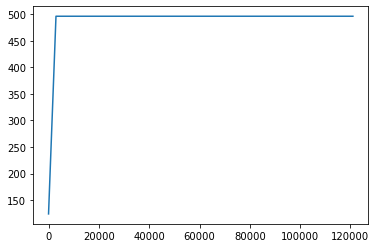

In [90]:
plt.plot()

# Emissions

In [152]:
bat_old = 2.68 * 39908 # (kg/l)*l
bat_gun = 2.68 * 41338
bat_gønn = 2.68 * 41460
bat_new = 2.68 * 39861
bat_sr = 2.68 * 39926

print('CO2-utslipp med 10 sek peakshaving: ',bat_old,' kg')
print('CO2-utslipp med batteri på 1000 kW : ',bat_gun,' kg')
print('CO2-utslipp med batteri på 100 kW: ',bat_gønn,' kg')
print('CO2-utslipp med peak shaving mellom 2.1 og 3 MW: ',bat_new,' kg')
print('CO2-utslipp med batteri kun spinning reserve: ',bat_sr,' kg')

CO2-utslipp med 10 sek peakshaving:  106953.44  kg
CO2-utslipp med batteri på 1000 kW :  110785.84000000001  kg
CO2-utslipp med batteri på 100 kW:  111112.8  kg
CO2-utslipp med peak shaving mellom 2.1 og 3 MW:  106827.48000000001  kg
CO2-utslipp med batteri kun spinning reserve:  107001.68000000001  kg
